<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/EBM_FIT_UNISIM_M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.metrics import r2_score

# df=pd.read_excel('unisim_hist-m.xlsx').iloc[1:,:]
df=pd.read_excel('unisim_hist-m.xlsx').iloc[1:49,:]
df.head()

,Date,Press,Np,Gp,Wp,Winj
1,2013-06-30,332,0,0,0,0
2,2013-07-31,331,61938,6858068,0,0
3,2013-08-31,329,124403,13532213,0,0
4,2013-09-30,328,182423,20112443,0,0
5,2013-10-31,327,244857,26856741,0,0


In [2117]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Rsi = 113.06
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
pb = 210.03
bob = 1.414
co = 1.62E-04
cw = 4.76E-05
Swi = 0.17

In [2118]:
df["t"] = (df["Date"]-df["Date"].iloc[0]).astype("int64")/10**9/60/60/24
df["dt"]=df["t"].diff().fillna(0)
# df["p_med"]= (df["Press"]+(df["Press"]-df["Press"].diff()).fillna(df["Press"].iloc[0]))/2
# df["dp"]= df["Press"].iloc[0]-df["Press"]
# df["pmt"]=((df["Press"].iloc[0]-df["p_med"])*df["dt"]).cumsum()
df.tail()

,Date,Press,Np,Gp,Wp,Winj,t,dt
44,2017-01-31,239,3901232,436942450,99236,0,1311.0,31.0
45,2017-02-28,239,3935560,440690194,101000,0,1339.0,28.0
46,2017-03-31,238,3976697,445397947,103294,0,1370.0,31.0
47,2017-04-30,238,4016567,449776747,105244,0,1400.0,30.0
48,2017-05-31,238,4055999,454132495,107476,0,1431.0,31.0


In [2119]:
## PVT functions
print(Swi)
def func_bo(p, a, b):
    bo = np.zeros(len(p))
    for i in range(len(p)):
        if p[i] < pb:
          bo[i] = a * p[i] + b
        else:
          bo[i] = bob - co * (p[i] - pb)
    return bo

def func_bg(p, a, b):
    return a*p**(b)

def func_rs(p, a, b):
    rs = np.zeros(len(p))
    for i in range(len(p)):
      if p[i] < pb:
        rs[i] = a * p[i] + b
      else:
        rs[i] = Rsi
    return rs

0.17


In [2120]:
# EBM
# F/(Eo+mEg+(1+m)Efw)=N+We/(Eo+mEg+(1+m)Efw)
# We = F-N*(Eo+mEg+(1+m)Efw)

# Bt=Bo+(Rsi-Rs)*Bg
# F = Np*(Bt+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rsi-Rs)*Bg+(Rp-Rsi)*Bg)+(Wp-Winj)*Bw
# F = Np*(Bo+(Rp-Rs)*Bg)+(Wp-Winj)*Bw

# Eo= Bt-Bti

# Eg= Boi*(Bg/Bgi-1)

# Efw = Boi*((cf+cw.Swi)/(1-Swi))*∆p
# Efw = Boi*((cf+cw.Swi)/(1-Swi))*(pi-p)

p = df["Press"].values

bo = func_bo(p, 0.0012, 1.1538)
df["Bo"]=bo

bg = func_bg(p, 1.40676, -1.04229)
df["Bg"]=bg

rs = func_rs(p, 0.4655, 15.0114)
df["Rs"]=rs
df["Rp"] = (df["Gp"]/df["Np"]).fillna(0)

# df["Bt"]=df["Bo"]+(Rsi-df["Rs"])*df["Bg"]
# df["F"] = df["Np"]*(df["Bt"]+(df["Rp"]-Rsi)*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
df["F"] = df["Np"]*(df["Bo"]+(df["Rp"]-df["Rs"])*df["Bg"])+(df["Wp"]-df["Winj"])*Bw
# df["Eo"] = df["Bt"]-df["Bt"].iloc[0]
df["Eo"] = df["Bo"]-df["Bo"].iloc[0]+(df["Rs"].iloc[0]-df["Rs"])*df["Bg"]
# df["Eg"] = df["Bt"].iloc[0]*(df["Bg"]/df["Bg"].iloc[0]-1)
df["Eg"] = df["Bo"].iloc[0]*((df["Bg"]/df["Bg"].iloc[0])-1)
# df["Efw"] = df["Bt"].iloc[0]*((cf+cw*Swi)/(1-Swi))*(df["Press"].iloc[0]-df["Press"])
df["Efw"] = (1+m)*df["Bo"].iloc[0]*((cf+cw*Swi)/(1-Swi))*(df["Press"].iloc[0]-df["Press"])

df.head()

,Date,Press,Np,Gp,Wp,Winj,t,dt,Bo,Bg,Rs,Rp,F,Eo,Eg,Efw
1,2013-06-30,332,0,0,0,0,0.0,0.0,1.394241,0.003315,113.06,0.000000,0.000000,0.000000,0.000000,0.000000
2,2013-07-31,331,61938,6858068,0,0,31.0,31.0,1.394403,0.003325,113.06,110.724725,85885.547962,0.000162,0.004391,0.000103
3,2013-08-31,329,124403,13532213,0,0,62.0,31.0,1.394727,0.003346,113.06,108.777224,171725.300945,0.000486,0.013254,0.000308
4,2013-09-30,328,182423,20112443,0,0,92.0,30.0,1.394889,0.003357,113.06,110.251684,252740.020631,0.000648,0.017727,0.000410
5,2013-10-31,327,244857,26856741,0,0,123.0,31.0,1.395051,0.003368,113.06,109.683370,338803.591700,0.000810,0.022227,0.000513


In [2121]:
train = df.copy()
# train = train.drop(["Gp", "Bt", "Bo", "Bg", "Rs", "F", "Eo", "Eg", "Efw", "p", "dt", "dp"], axis=1)

p=train["Press"].values
# p_med=train["p_med"].values
t=train["t"].values
dt=train["dt"].values
F=train["F"].values
Eo=train["Eo"].values
Eg=train["Eg"].values
Efw=train["Efw"].values
npp=train["Np"].values
gp=train["Gp"].values
rp=train["Rp"].values
wp=train["Wp"].values
winj=train["Winj"].values

Estimativa de N: 200.15
Estimativa de Wi: 1000.00
Estimativas de J: 8.98
[0.00000000e+00 2.77970851e+02 1.11111533e+03 2.18420828e+03
 3.56802728e+03 5.44159830e+03 7.92830012e+03 1.12420434e+04
 1.47294392e+04 1.96922152e+04 2.50198769e+04 3.13440733e+04
 3.85236889e+04 4.70343393e+04 5.69113280e+04 6.77887985e+04
 8.03881484e+04 9.25479194e+04 1.05356827e+05 1.18130343e+05
 1.29637372e+05 1.43455681e+05 1.58136962e+05 1.74378260e+05
 1.91128980e+05 2.09502884e+05 2.28659930e+05 2.47955655e+05
 2.68674277e+05 2.89208078e+05 3.10924598e+05 3.33137053e+05
 3.54381001e+05 3.77307293e+05 3.99702726e+05 4.23059731e+05
 4.45870848e+05 4.69656226e+05 4.93653852e+05 5.16814225e+05
 5.40959519e+05 5.64262407e+05 5.88554565e+05 6.12779602e+05
 6.34602741e+05 6.58978512e+05 6.82503835e+05 7.06747249e+05]
0.9116174927815571


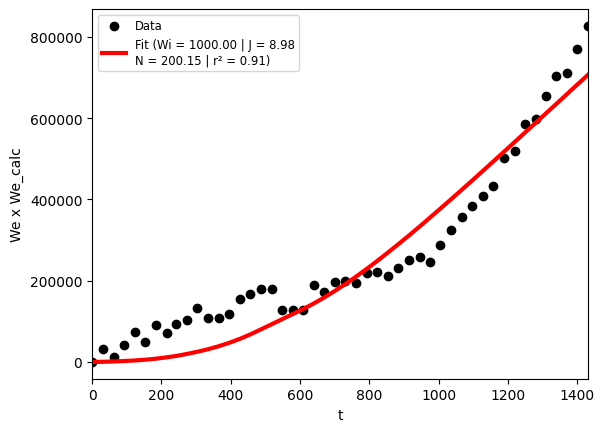

In [2122]:
## EBM generalizada
## We = F-N*(Eo+mEg+(1+m)Efw)
## F = N*(Eo+mEg+(1+m)Efw)+We

## Fetkovich
## ∆Wen = (Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## Wen = Wen-1+(Wei/pi).(pan-1-pn).[1-exp(-J.pi.∆t/Wei)]
## pan-1 = pi.[1-Wen-1/Wei]
## pn = [pn-1+pn]/2
## ∆t = t_j+1-t_j
## n = 1....n

##Aquífero Fetkovich

# Função objetivo
def objective(x, Eo, Eg, Efw, F, m):
    N = x[0]  # N é constante
    Wi = x[1]  # Wei é constante
    J = x[2]  # J é constante
    Wei = (cf+cw)*Wi*p[0]*10**6
    Wen = np.zeros(len(t))
    pa_med = np.zeros(len(t))
    pa_med[0] = p[0]
    for i in range(1,len(t)):
      pa_med[i-1]=p[0]*(1-(Wen[i-1]/Wei))
      Wen[i]=Wen[i-1]+(Wei/p[0])*(pa_med[i-1]-p[i])*(1-np.exp(-J*p[0]*dt[i]/Wei))
    We_EBM = F - (N*10**6) * (Eo + m * Eg + Efw)
    return np.sum((We_EBM - Wen) ** 2)

# Chute inicial para N, Wi e J
x0 = np.array([130] + [100] + [10])

# Limites para N, Wi e J
bounds = [(10, 1000)] + [(10, 1000)] + [(1, 100)]

# Otimização com restrições
result = minimize(objective, x0, args=(Eo, Eg, Efw, F, m), bounds=bounds)

N_est = result.x[0]
Wi_est = result.x[1]
J_est = result.x[2]

print(f"Estimativa de N: {N_est:0.2f}")
print(f"Estimativa de Wi: {Wi_est:0.2f}")
print(f"Estimativas de J: {J_est:0.2f}")

Wei_est = (cf+cw)*Wi_est*p[0]*10**6
# print(Wei_est)
Wen = np.zeros(len(t))
pa_med = np.zeros(len(t))
pa_med[0] = p[0]
for i in range(1,len(t)):
  pa_med[i-1] = p[0]*(1-(Wen[i-1]/Wei_est))
  Wen[i] = Wen[i-1]+(Wei_est/p[0])*(pa_med[i-1]-p[i])*(1-np.exp(-J_est*p[0]*dt[i]/Wei_est))
pa_med[len(t)-1] = p[0]*(1-(Wen[len(t)-1]/Wei_est))
We_EBM = F - (N_est*10**6) * (Eo + m * Eg + Efw)
print(Wen)

r2_2 = r2_score(We_EBM, Wen)
print(r2_2)

plt.scatter(t, We_EBM, label="Data", color="black")
plt.plot(t, Wen, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("We x We_calc")
plt.xlim(0, 1431)
plt.show()

[332.         330.38682105 328.78303806 327.27710543 325.68476996
 324.175375   321.44668257 318.88357174 316.54491004 312.44531482
 310.00116085 307.61203492 303.73508418 299.71943206 294.24101481
 289.20350774 284.21378172 284.45221874 284.6966443  284.93911526
 285.1565093  280.23392367 275.82911809 271.69180265 267.95770446
 264.4137724  261.29266957 258.63261781 256.18897573 254.1956389
 252.22806778 250.52887948 249.13857552 247.77576755 246.49757791
 245.31028409 244.21676257 243.20289273 242.19487117 241.31702678
 240.44498615 239.63994888 238.86942185 238.23854398 237.71546253
 237.02946076 236.38767606 235.76694803]


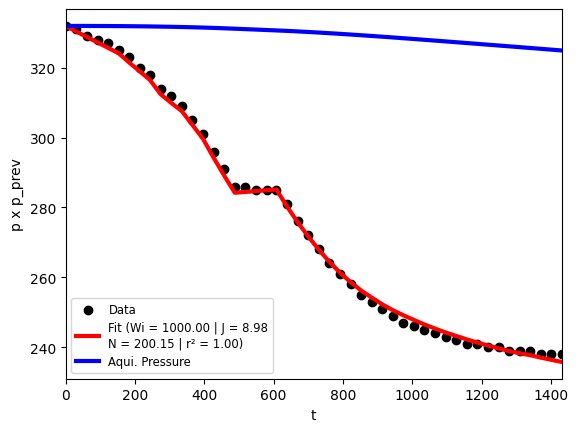

In [2123]:
## Previsao de pressao

p_prev=np.zeros(len(t))
we_aquif=np.zeros(len(t))
ppa_med=np.zeros(len(t))
we_ebm=np.zeros(len(t))

for i in range(len(t)):
  if i == 0:
    p_prev[i]=p[0]
    we_aquif[i]=0
    ppa_med[i]=p[0]
    we_ebm[i]=0
  else:
    # Função objetivo
    def obj_f(x, m, N, Wei, J):
      pn = x[0]  # pressao prevista

      ## Aquifero
      ppa_med[i-1]=p[0]*(1-(we_aquif[i-1]/Wei))
      we_aquif[i]=we_aquif[i-1]+(Wei/p[0])*(ppa_med[i-1]-pn)*(1-np.exp(-J*p[0]*dt[i]/Wei))

      ## EBM
      if pn < pb:
        bop = 1.40676 * pn - 1.04229
        rsp = 0.4655 * pn + 15.0114
      else:
        bop = bob - co * (pn - pb)
        rsp = Rsi
        bgp = 1.40676*pn**(-1.04229)
        fp=npp[i]*(bop+(rp[i]-rsp)*bgp)+(wp[i]-winj[i])*Bw
        eop=bop-bo[0]+(Rsi-rsp)*bgp
        egp=bo[0]*((bgp/bg[0])-1)
        efwp=(1+m)*bo[0]*((cf+cw*Swi)/(1-Swi))*(p[0]-pn)
        we_ebm[i]=fp-N*(eop+m*egp+efwp)*10**6

      return (we_ebm[i] - we_aquif[i]) ** 2

    x0 = [p_prev[i-1]]
    result = minimize(obj_f, x0, args=(m, N_est, Wei_est, J_est))
    p_prev[i]=result.x[0]

r2_2 = r2_score(p, p_prev)
print(p_prev)

plt.scatter(t, p, label="Data", color="black")
plt.plot(t, p_prev, label=f"Fit (Wi = {Wi_est:0.2f} | J = {J_est:0.2f}" + "\n" + f"N = {N_est:0.2f} | r\N{SUPERSCRIPT TWO} = {r2_2:.2f})", color="red", linewidth=3)
plt.plot(t, pa_med, label="Aqui. Pressure", color="blue", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("p x p_prev")
plt.xlim(0, 1431)
plt.show()

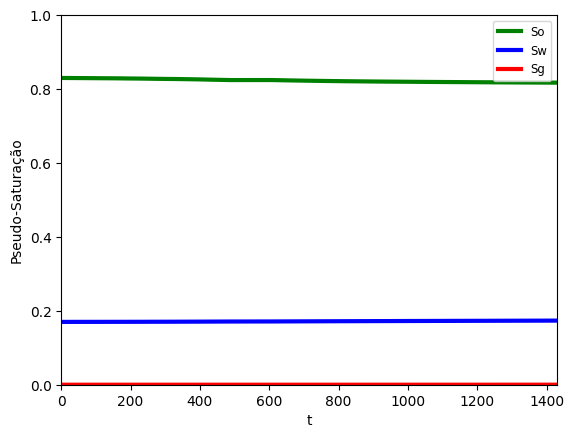

In [2124]:
## Saturacoes de fluidos

So = np.zeros(len(t))
Sw = np.zeros(len(t))
Sg = np.zeros(len(t))
cct = np.zeros(len(t))
Vpp = np.zeros(len(t))
Vp = (N_est*10**6) * bo[0] / (1 - Swi)
G = ((N_est*10**6) * Rsi + m * (N_est*10**6) * bo[0] / bg[0])
# print(G)

for i in range(len(t)):
  cct[i] = (1 + (Swi * cw / (1 - Swi) + cf) * (p_prev[i] - p[0]))
  Vpp[i] = Vp * (1 + cf * (p[i] - p[0]))
  So[i] = ((N_est*10**6) - npp[i]) *bo[0] / Vpp[i]
  Sw[i] = (Swi * Vp * (1 - cw * (p_prev[i] - p[0])) + ((winj[i] - wp[i] + Wen[i]) * Bw)) / Vpp[i]
  Sg[i] = bg[i] * (G - gp[i] - ((N_est*10**6) - npp[i]) * rs[i] - cct[i] * m * (N_est*10**6) * bo[0] / bg[0]) / Vpp[i]

# print(Sg)

plt.plot(t, So, label="So", color="green", linewidth=3)
plt.plot(t, Sw, label="Sw", color="blue", linewidth=3)
plt.plot(t, Sg, label="Sg", color="red", linewidth=3)
plt.legend(fontsize='small')
plt.xlabel("t")
plt.ylabel("Pseudo-Saturação")
plt.ylim(0.0, 1.0)
plt.xlim(0, 1431)
plt.show()

In [2125]:
date=df["Date"].values
date_time=pd.to_datetime(date)
date_time

DatetimeIndex(['2013-06-30', '2013-07-31', '2013-08-31', '2013-09-30',
               '2013-10-31', '2013-11-30', '2013-12-31', '2014-01-31',
               '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-31',
               '2014-06-30', '2014-07-31', '2014-08-31', '2014-09-30',
               '2014-10-31', '2014-11-30', '2014-12-31', '2015-01-31',
               '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31',
               '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30',
               '2015-10-31', '2015-11-30', '2015-12-31', '2016-01-31',
               '2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31',
               '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30',
               '2016-10-31', '2016-11-30', '2016-12-31', '2017-01-31',
               '2017-02-28', '2017-03-31', '2017-04-30', '2017-05-31'],
              dtype='datetime64[ns]', freq=None)

In [2126]:
from pandas.tseries.offsets import MonthEnd

# Última data fornecida
last_date = date_time[-1]

# Gerar 24 novas datas, no último dia de cada mês seguinte
new_dates = pd.to_datetime([last_date + MonthEnd(n) for n in range(1, 25)])
new_dates

# (new_dates[0]-date_time[-1]).days

DatetimeIndex(['2017-06-30', '2017-07-31', '2017-08-31', '2017-09-30',
               '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31',
               '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31'],
              dtype='datetime64[ns]', freq=None)

In [2127]:
## Forecast

fc = pd.DataFrame(new_dates, columns=['Date'])
fc = pd.concat([df, fc], ignore_index=True).iloc[:,:].fillna(0)
fc

,Date,Press,Np,Gp,Wp,Winj,t,dt,Bo,Bg,Rs,Rp,F,Eo,Eg,Efw
0,2013-06-30,332.0,0.0,0.0,0.0,0.0,0.0,0.0,1.394241,0.003315,113.06,0.000000,0.000000,0.000000,0.000000,0.000000
1,2013-07-31,331.0,61938.0,6858068.0,0.0,0.0,31.0,31.0,1.394403,0.003325,113.06,110.724725,85885.547962,0.000162,0.004391,0.000103
2,2013-08-31,329.0,124403.0,13532213.0,0.0,0.0,62.0,31.0,1.394727,0.003346,113.06,108.777224,171725.300945,0.000486,0.013254,0.000308
3,2013-09-30,328.0,182423.0,20112443.0,0.0,0.0,92.0,30.0,1.394889,0.003357,113.06,110.251684,252740.020631,0.000648,0.017727,0.000410
4,2013-10-31,327.0,244857.0,26856741.0,0.0,0.0,123.0,31.0,1.395051,0.003368,113.06,109.683370,338803.591700,0.000810,0.022227,0.000513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2019-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
68,2019-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
69,2019-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
70,2019-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [2128]:
fc.iloc[-1, 1] = "Novo valor"
fc

,Date,Press,Np,Gp,Wp,Winj,t,dt,Bo,Bg,Rs,Rp,F,Eo,Eg,Efw
0,2013-06-30,332.0,0.0,0.0,0.0,0.0,0.0,0.0,1.394241,0.003315,113.06,0.000000,0.000000,0.000000,0.000000,0.000000
1,2013-07-31,331.0,61938.0,6858068.0,0.0,0.0,31.0,31.0,1.394403,0.003325,113.06,110.724725,85885.547962,0.000162,0.004391,0.000103
2,2013-08-31,329.0,124403.0,13532213.0,0.0,0.0,62.0,31.0,1.394727,0.003346,113.06,108.777224,171725.300945,0.000486,0.013254,0.000308
3,2013-09-30,328.0,182423.0,20112443.0,0.0,0.0,92.0,30.0,1.394889,0.003357,113.06,110.251684,252740.020631,0.000648,0.017727,0.000410
4,2013-10-31,327.0,244857.0,26856741.0,0.0,0.0,123.0,31.0,1.395051,0.003368,113.06,109.683370,338803.591700,0.000810,0.022227,0.000513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2019-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
68,2019-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
69,2019-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
70,2019-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
